<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 6.2: K-Means bad cases

INSTRUCTIONS:

- Replace the `___` with proper code to run the cells
- Observe and understand the results
- Answer the questions

In [1]:
## Import Libraries

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

# from sklearn import datasets
from sklearn.datasets import make_circles
import seaborn as sns

In [2]:
## Create data points (circles)

# Make Random Circles
X1, _ = make_circles(n_samples = 400, factor = 0.3, noise = 0.05)

In [3]:
## Convert data into a DataFrame

# Declare the column names
columns = 'A B'.split()

# Load the dataset as a pandas data frame
X = pd.DataFrame(X1, columns = columns)

In [4]:
## Check data

# About X
print('X is a %s' % type(X))
print('X has %d rows and %d columns' % X.shape)
print('Basic Statistics about X%s' % ('_'*50))
print(X.describe())
print('')
print('Sample of X%s' % ('_'*50))
print(X.head())

X is a <class 'pandas.core.frame.DataFrame'>
X has 400 rows and 2 columns
Basic Statistics about X__________________________________________________
                A           B
count  400.000000  400.000000
mean    -0.003468   -0.002774
std      0.524540    0.523758
min     -1.097324   -1.059243
25%     -0.283035   -0.286464
50%     -0.004510    0.000904
75%      0.285278    0.292722
max      1.068116    1.084386

Sample of X__________________________________________________
          A         B
0 -0.189410  0.166842
1 -0.220495 -0.016772
2 -0.610681  0.858026
3  0.847313  0.577072
4  0.250819 -0.122549


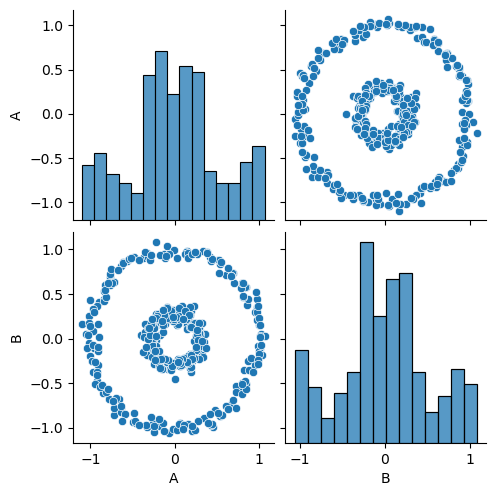

In [5]:
sns.pairplot(X)
plt.show()

### Question: What are other important things to know about the data? Comment on:
- Types
- Availability
- Dispersion and Distribution

### Question: Which features could/should be used to cluster the data points?

In [8]:
## Create some supporting functions
def print_centroids(centroids):
    global step
    if show_steps:
        print('(Step) Step %d' % step)
        for c in centroids:
            print(', '.join(['%.3f' % f for f in c]))
        step += 1

# Create new centroids randomly for all the K clusters including all dimensions
def create_centroids(K, features):
    # start with No centroids
    centroids = []
    # need one centroid for each cluster
    for i in range(K):
        # it can be multi-dimensional
        dimensions = []
        for f in features:
            # create a random number between the minimum and maximum of each feature
            x = np.random.uniform(X[f].min(), X[f].max())
            dimensions.append(x)
        # add all dimensions for the centroids of each cluster
        centroids.append(dimensions)
    print_centroids(centroids)
    return centroids

In [9]:
# Identify the closest centroid for a given data point
def closest_centroid(x, centroids):
    distances = []
    # convert x to a numpy.array; x contains all the features of a data point
    p = np.array(x)
    for c in centroids:
        # convert c to a numpy.array; c contains the coordinates for all the features
        q = np.array(c)
        # calculate the Euclidean distance between data point `x` and centroid `c`
        d = np.sqrt( np.square(p - q).sum())
        # add the distance for each centroid
        distances.append(d)

    # return the position (cluster) which has the smallest distance
    return np.array(distances).argmin()

In [10]:
# recalculate all the centroids based on the mean of the members of each cluster
def update_centroid(X, y, centroids):
    c = []
    # for each of the existing centroids
    for i in range(len(centroids)):
        # check if any object was assigned to a cluster
        if X[y == i].shape[0]:
            dimensions = []
            # for all the features
            for f in X.columns:
                # calculate the mean
                x = X[f][y == i].mean()
                dimensions.append(x)
            c.append(dimensions)
        # if a cluster got no members
        else:
            # keep the previous coordinates
            c.append(centroids[i])

    return c

In [11]:
# plot a chart of the data points and centroids either generic or identifying the clusters
# NOTE: for visualisation purposes, only consider the first two features
def plot_data(ax, X, y, centroids, show_clusters = True):
    # unpack the coordinates of the centroids
    a = [z[0] for z in centroids]
    b = [z[1] for z in centroids]

    # show distinct colours if asked to identify the clusters
    if show_clusters:
        colours = 'rgbykcm'
        for i in range(len(centroids)):
            ax.scatter(X[features[0]][y == i], X[features[1]][y == i], c = colours[i], label = 'Cluster %d' % i)
    # show data points without cluster identification
    else:
        ax.scatter(X[features[0]], X[features[1]], label = 'Data Point')
        
    # label the features
    ax.set_xlabel(features[0])
    ax.set_ylabel(features[1])

    # identify the centroids
    ax.scatter(a, b, c = 'k', linewidths = 5, marker = 'x', label = 'Centroid')
    for i in range(len(a)):
        c = colours[i] if show_clusters else 'k'
        ax.axvline(x = a[i], color = c, linestyle = '--', linewidth = 1)
        ax.axhline(y = b[i], color = c, linestyle = '--', linewidth = 1)

    # create a text to show the centroids' coordinates
    t = '\n'.join(['%d: (%.3f, %.3f)' % (i, a, b) for (i, (a, b)) in enumerate(centroids)])
    ax.text(0.69, -1.1, t)

    ax.legend()

In [21]:
step = 0
show_steps = True

(Step) Step 14
-0.963, 0.459
0.752, -0.273
-0.002, -0.541


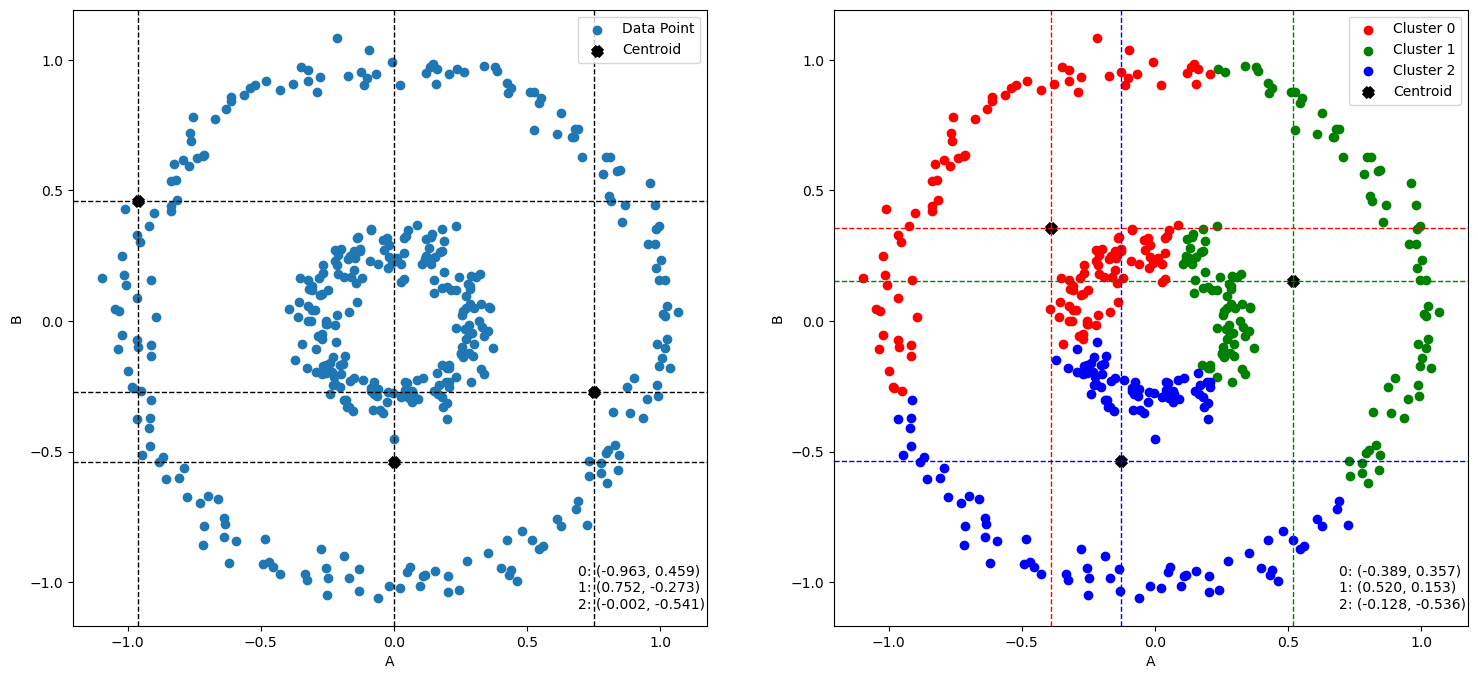

In [36]:
## K_Means
## Note that the comments match the outlined K-Means Algorithm in the presentation

# 1. Define the number of clusters `K`
K = 3 # choose different values for `K`

# list the features to be used
features = ['A', 'B']

# 2. Select `K` cluster centres randomly
centroids = create_centroids(K, features)

# plot the data points and initial centroids (the 'Before')
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 8))
plot_data(axes[0], X[features], None, centroids, False)

# repeat util makes no moves
while True:
    # 3. Calculate the distance between each data point and cluster centres
    # 4. Assign the data point to the cluster whose distance from its centre is minimum
    y = X[features].apply(lambda x: closest_centroid(x, centroids), axis = 1).values

    # move the known assignment be the previous state, for post comparison
    old_c = centroids.copy()

    # 5. Recalculate all new cluster centres by averaging the objects of each cluster
    centroids = update_centroid(X[features], y, centroids)

    # 6. Repeat steps 3 to 5 until the centroids do not change
    if old_c == centroids:
        break

# plot the data points identified by cluster and final centroids (the 'After')
plot_data(axes[1], X[features], y, centroids)
plt.show()

## Question: What happens if the algorithm is run multiple times?
### When you run the centroid moves all the time and you will get different clusters everytime

## Question: What happens if `K` is changed?
### It groups them according to their closest one and when we have big value for k the cluster is small and vice-versa

>

>

>



---



---



> > > > > > > > > © 2022 Institute of Data


---



---



